In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import poisson

In [2]:
def ColumnNames():
    return ['col1', 'col2', 'col3', 'average']

def PreProcess(filepath, skiprows, usecols): 
    """
    This function reads data and add min, max, include_mean values.
    
    Parameters
    ----------
    filepath : filepath of the data
    skiprows: number of rows to skip from the csv file
    usecols: range of columns of data to read in.
               
    Returns
    -------
    data : The original count data and some added columns of new stats data.
    """
    print 'Reading Data from \"{0}\"'.format(os.path.basename(filepath))
    data = pd.read_csv(filepath, skiprows=skiprows,usecols=usecols,na_values=' ', header = None, names = ColumnNames() ).dropna(axis=0)
    data['col_min'] = data.apply(lambda row: min(row['col1'],row['col2'],row['col3']), axis=1)
    data['col_max'] = data.apply(lambda row: max(row['col1'],row['col2'],row['col3']), axis=1)
    data['col_median'] = data.apply(lambda row: np.median([row['col1'],row['col2'],row['col3']]), axis=1)
    data['col_gap'] = data['col_max']-data['col_min']
    data['complete'] = data['col_gap']>=2
    data['include_mean'] = data.apply(lambda row: ((row['col1'] == round(row['average']) or row['col2'] == round(row['average']) or 
                                                               row['col3'] == round(row['average'])) and row['complete']),axis=1)
    return  data

def GetStats(data):
    """
    This function reads data and print relevant stats.
    
    Parameters
    ----------
    data : preprocessed data with the desired columns
    """    
    total = len(data)
    complete = len(data[data['complete']])
    no_mean = len(data[data['include_mean'] == True])
    #mid_ratio = data[data['complete']].apply(lambda row: (row['col_median']-row['col_min'])/row['col_gap'], axis=1)
    #plt.figure();
    #sns.distplot(mid_ratio, bins=10, norm_hist=True)
    print 'total:{0}, number_of_complete:{1}, number_of_mean:{2}'.format(total, complete, no_mean)
    
def MidRatioHistPlot(data):
    mid_ratio = data[data['complete']].apply(lambda row: (row['col_median']-row['col_min'])/row['col_gap'], axis=1)
    mid_ratio_value, mid_ratio_range = np.histogram(mid_ratio, bins = 10)
    mid_ratio_percentage = mid_ratio_value/float(len(mid_ratio)) * 100
    plt.bar(np.arange(0,10), mid_ratio_percentage)
    plt.axis([0, 10, 0, 1.5*max(mid_ratio_percentage)])
    plt.xticks(np.arange(0,10), mid_ratio_range)
    plt.xlabel('Mid ratio range')
    plt.ylabel('Percentage')
    plt.show()

In [3]:
data_dir = '../data/PittHill_OSFdata_2016/csv/'
rts_colony = PreProcess(os.path.join(data_dir,'Bishayee Colony Counts 10.27.97-3.8.01.csv'),3,range(3,7))
others_colony = PreProcess(os.path.join(data_dir,'Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv'),2,range(3,7))
rts_coulter = PreProcess(os.path.join(data_dir,'Bishayee Coulter Counts.10.20.97-7.16.01.csv'),2,range(2,6))
#rts_coulter = PreProcess(os.path.join(data_dir,'Bishayee Coulter Counts.10.20.97-7.16.01.csv'),2,range(2,6))
#others_coulter = PreProcess(os.path.join(data_dir,'Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.csv'),2,range(2,6))

Reading Data from "Bishayee Colony Counts 10.27.97-3.8.01.csv"
Reading Data from "Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv"
Reading Data from "Bishayee Coulter Counts.10.20.97-7.16.01.csv"


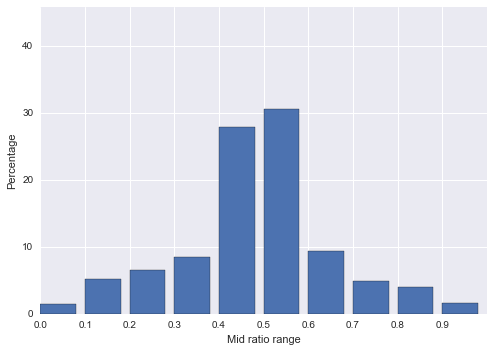

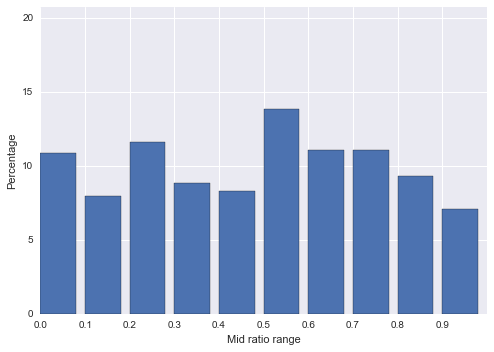

In [4]:
MidRatioHistPlot(rts_colony)
MidRatioHistPlot(others_colony)

In [5]:
GetStats(rts_colony)
GetStats(others_colony)
GetStats(rts_coulter)
#GetStats(rts_coulter)
#GetStats(others_coulter)


total:1361, number_of_complete:1343, number_of_mean:690
total:597, number_of_complete:578, number_of_mean:109
total:1727, number_of_complete:1726, number_of_mean:176


In [11]:
def ChooseN(moment):
    MAX_N = 1000000
    EPSILON = 1e-9
    prob_sum = 0
    for j in range(0, MAX_N):
        prob_sum = prob_sum + poisson.pmf(j, moment)
        if prob_sum >= 1-EPSILON:
            #print 'For moment: {0}, Choose N:{1}'.format(moment, j)
            return j
        
def PoissonMidRatio(moment, left_ratio, right_ratio):
    prob = 0
    N = ChooseN(moment)
    for j in list(range(2, N + 1)):
        for k in list(range(j, N + 1)):
            inner = poisson.cdf(min(k,math.floor(right_ratio*j+k-j)), moment) - poisson.cdf(max(k-j,math.floor(left_ratio*j+k-j)), moment)
            outer = poisson.pmf(k, moment) * poisson.pmf(k - j, moment)
            prob = prob + outer * inner    
    prob = 6 * prob
    return(prob)

In [12]:
leftRatio = 0.4
rightRatio = 0.6
poisMoments = range(1, 101) # each mean-variance parameter of the Poisson distribution
probs = np.zeros(len(poisMoments))

# Computing the probability of the mid ratio between leftRatio and rightRatio
for i in range(len(poisMoments)):
    if i%20 == 0:
        print 'Processed to moment {0}'.format(i)
    probs[i] = PoissonMidRatio(poisMoments[i], leftRatio, rightRatio)
print 'Process Done'

Processed to moment 0
Processed to moment 20
Processed to moment 40
Processed to moment 60
Processed to moment 80
Process Done


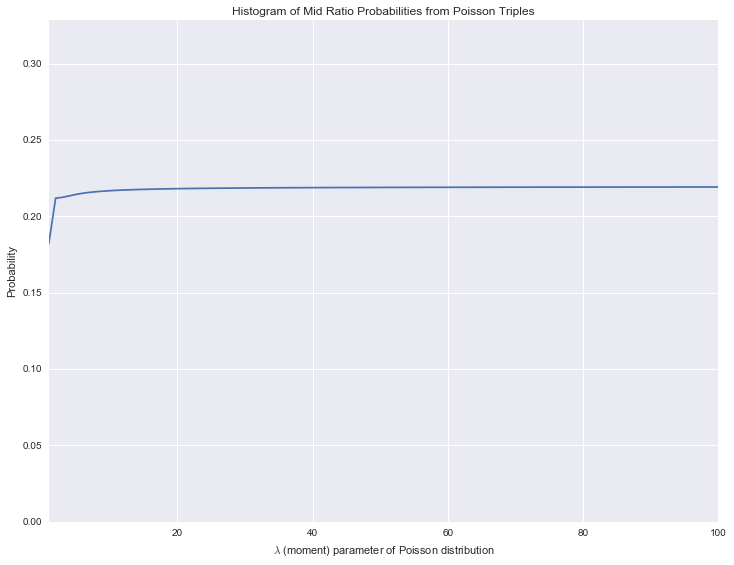

In [13]:
plt.figure(num = None, figsize=(12, 9), dpi=80)
plt.plot(poisMoments, probs)
plt.xlabel('$\lambda$ (moment) parameter of Poisson distribution')
plt.ylabel('Probability')
plt.title(r'Histogram of Mid Ratio Probabilities from Poisson Triples')
plt.axis([min(poisMoments), max(poisMoments), 0, min(1.5 * max(probs), 1)])
plt.show()